<a href="https://colab.research.google.com/github/BigBubl1k/Emotion_recognition_from_voice/blob/main/UltraPro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#нейронка по определению эмоций из аудио (база с kaggle)

In [ ]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков

from tensorflow.keras.optimizers import Adam, RMSprop #Подключаем оптимизаторы
from tensorflow.keras.models import Sequential, Model #Модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Базовые слои
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

In [ ]:
from google.colab import drive #подключаем библиотеку для работы с google диском
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q '/content/drive/MyDrive/Dataset.zip' #распаковываем архив на google диске на локальный диск google colaboratory 

Dataset = os.listdir('Dataset') # получаем список папок в распакованной папке

#Проверяем выгруженные папки
!ls Dataset 
#И одну из папок
!ls Dataset/Angry

Angry  Calm  Disgust  Fearful  Happy  Neutral  Sad
03-01-05-01-01-01-01.wav  1037_ITH_ANG_XX.wav  1087_IEO_ANG_MD.wav
03-01-05-01-01-01-02.wav  1037_ITS_ANG_XX.wav  1087_IOM_ANG_XX.wav
03-01-05-01-01-01-03.wav  1037_IWL_ANG_XX.wav  1087_ITH_ANG_XX.wav
03-01-05-01-01-01-04.wav  1037_IWW_ANG_XX.wav  1087_ITS_ANG_XX.wav
03-01-05-01-01-01-05.wav  1037_MTI_ANG_XX.wav  1087_IWL_ANG_XX.wav
03-01-05-01-01-01-06.wav  1037_TAI_ANG_XX.wav  1087_IWW_ANG_XX.wav
03-01-05-01-01-01-07.wav  1037_TIE_ANG_XX.wav  1087_MTI_ANG_XX.wav
03-01-05-01-01-01-08.wav  1037_TSI_ANG_XX.wav  1087_TAI_ANG_XX.wav
03-01-05-01-01-01-09.wav  1037_WSI_ANG_XX.wav  1087_TIE_ANG_XX.wav
03-01-05-01-01-01-10.wav  1038_DFA_ANG_XX.wav  1087_TSI_ANG_XX.wav
03-01-05-01-01-01-11.wav  1038_IEO_ANG_HI.wav  1087_WSI_ANG_XX.wav
03-01-05-01-01-01-12.wav  1038_IEO_ANG_LO.wav  1088_DFA_ANG_XX.wav
03-01-05-01-01-01-13.wav  1038_IEO_ANG_MD.wav  1088_IEO_ANG_HI.wav
03-01-05-01-01-01-14.wav  1038_IOM_ANG_XX.wav  1088_IEO_ANG_LO.wav
03-01-05-01

In [ ]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)
  
  rmse = np.mean(librosa.feature.rms(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #среднее частота пересечения нуля звукового временного ряда
  
  
  #Добавляем все параметры в один список
  out = [] # создаем пустой список
  out.append(rmse) #  добавляем среднеквадратичную амплитуду
  out.append(spec_cent) #добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля
  
  #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time #подключаем модуль time для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(Dataset)):
  g = Dataset[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./Dataset/{g}'):
    #Получаем имя песни
    songname = f'./Dataset/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 3 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=1) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(to_categorical(i, len(Dataset)))

  #Выводим информацию о готовности обработки базы
  print("Эмоция ", g, " готова -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Эмоция Sad готова -> 151c
Эмоция Neutral готова -> 133c
Эмоция Angry готова -> 152c
Эмоция Happy готова -> 150c
Эмоция Fearful готова -> 142c
Эмоция Disgust готова -> 142c
Эмоция Calm готова -> 21c


In [ ]:
#Создаём backup обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 ... 6 6 6]


In [ ]:
#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(12187, 37)
(12187, 7)
(12187,)


In [ ]:
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [ ]:
print(X_train[0])

[ 2.23246776 -1.2119768  -1.95255929 -1.58232431 -0.92409123  0.43428495
 -0.62846188  0.56162739  0.34569344  1.69263223 -1.29326878  1.87840516
 -0.6889922   0.56851023  0.33894086  0.45486079  0.16882914  0.02488025
  0.80644782  0.46609322  1.23755859 -0.22897391  0.99276968  0.32782673
  0.02038844  1.26407591  1.62245226  2.81380144  2.39987045  1.69637429
  1.55214209  1.58781056  1.29485925  1.0929123   1.15367208  0.53521651
  0.78296685]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size = 0.1)

In [ ]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10968, 37)
(10968,)
(1219, 37)
(1219,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
549/549 [==============================] - 2s 2ms/step - loss: 1.5864 - accuracy: 0.4027 - val_loss: 1.4530 - val_accuracy: 0.4364
Epoch 2/200
549/549 [==============================] - 1s 2ms/step - loss: 1.3669 - accuracy: 0.4680 - val_loss: 1.3621 - val_accuracy: 0.4586
Epoch 3/200
549/549 [==============================] - 1s 2ms/step - loss: 1.3017 - accuracy: 0.4854 - val_loss: 1.3206 - val_accuracy: 0.4881
Epoch 4/200
549/549 [==============================] - 1s 2ms/step - loss: 1.2636 - accuracy: 0.4946 - val_loss: 1.2951 - val_accuracy: 0.4824
Epoch 5/200
549/549 [==============================] - 1s 2ms/step - loss: 1.2397 - accuracy: 0.5001 - val_loss: 1.2723 - val_accuracy: 0.4873
Epoch 6/200
549/549 [==============================] - 1s 2ms/step - loss: 1.2197 - accuracy: 0.5108 - val_loss: 1.2555 - val_accuracy: 0.5004
Epoch 7/200
549/549 [==============================] - 1s 2ms/step - loss: 1.2057 - accuracy: 0.5108 - val_loss: 1.2586 - val_accuracy: 0.4988

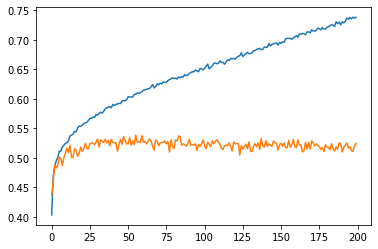

In [ ]:
indexes = range(0,37)

#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(Dataset), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

точность вышла 52% 